<a href="https://colab.research.google.com/github/JamionW/Advanced-Analysis-of-Algorithms/blob/master/Inverse_Elasticity_with_Decay_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import numpy as np
import fiona
import geopandas as gpd

### Dataset Imports

In [3]:
# ADDRESSES

# Read in addresses
# this takes about 20 minutes for the State of Tennessee
# less than a minute for Chattanooga

# Read the GeoJSON file into a GeoDataFrame
#address_df = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/tennessee.geojson')

# Chattanooga, for testing
address_df = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/chattanooga.geojson')

In [4]:
#SVI

gdb_file = "/content/drive/MyDrive/Colab Notebooks/data/SVI2022_TENNESSEE_tract.gdb"

layers = fiona.listlayers(gdb_file)

svi_df = gpd.read_file(gdb_file, layer='SVI2022_TENNESSEE_tract')


In [5]:
# ROADS

# Import shapefiles
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php

# documentation here: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2023/TGRSHP2023_TechDoc.pdf

# Open the shapefile as a Fiona collection
with fiona.open('/content/drive/MyDrive/Colab Notebooks/data/tl_2023_47065_roads.shp') as collection:
    # Create a GeoDataFrame from the collection
    roads_df = gpd.GeoDataFrame.from_features(collection)


In [6]:
# Ensure all data is in the same CRS
target_crs = "EPSG:32618"  # UTM zone 18N
roads_df = roads_df.set_crs(target_crs)
address_df = address_df.to_crs(target_crs)
svi_df = svi_df.to_crs(target_crs)

### Graph Creation

In [7]:
def create_graph_from_roads(roads_gdf):
    G = nx.Graph()
    for idx, row in roads_gdf.iterrows():
        if row.geometry.geom_type == 'LineString':
            start = row.geometry.coords[0]
            end = row.geometry.coords[-1]
            G.add_edge(start, end, geometry=row.geometry, length=row.geometry.length)
        elif row.geometry.geom_type == 'MultiLineString':
            for line in row.geometry:
                start = line.coords[0]
                end = line.coords[-1]
                G.add_edge(start, end, geometry=line, length=line.length)
    return G

G = create_graph_from_roads(roads_df)

In [8]:
import numpy as np

# Add edge lengths if missing
for u, v, data in G.edges(data=True):
    if 'length' not in data:
        data['length'] = np.sqrt((G.nodes[u]['pos'][0] - G.nodes[v]['pos'][0])**2 +
                                 (G.nodes[u]['pos'][1] - G.nodes[v]['pos'][1])**2)

In [9]:
import pyproj
from shapely.ops import transform

# Define the transformation
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32618')
project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

# Project the graph
G_projected = G.copy()
for node in G_projected.nodes():
    point = transform(project, Point(node))
    G_projected.nodes[node]['pos'] = (point.x, point.y)

for u, v, data in G_projected.edges(data=True):
    point1 = Point(G_projected.nodes[u]['pos'])
    point2 = Point(G_projected.nodes[v]['pos'])
    data['length'] = point1.distance(point2)

# Use G_projected instead of G in your calculations

### Elasticity with Decay

*   Increase lambda_param to make the influence decay more quickly
with distance.
*   Decrease lambda_param to allow influence to extend further.
*   Increase beta to make the function more sensitive to SVI differences.
*   Decrease beta to make the function less sensitive to SVI differences.

In [13]:
import numpy as np

def calculate_inverse_elasticity(G, target_tract, address_gdf, svi_gdf, lambda_param=0.001, beta=1):
    """
    Calculate inverse elasticity using exponential decay for distance and power law for SVI difference.

    Parameters:
    - G: NetworkX graph (not used in this implementation, but kept for consistency)
    - target_tract: GeoDataFrame row representing the target census tract
    - address_gdf: GeoDataFrame of addresses
    - svi_gdf: GeoDataFrame of census tracts with SVI data
    - lambda_param: Controls the rate of exponential decay with distance (default 0.001)
    - beta: Exponent for SVI difference (default 1)

    Returns:
    - DataFrame with calculated inverse elasticities
    """
    print("Starting calculate_inverse_elasticity")
    print(f"Addresses in address_gdf: {len(address_gdf)}")

    target_geometry = target_tract.geometry
    print(f"Target tract area: {target_geometry.area}")

    # Get addresses within the target tract
    addresses_within = address_gdf[address_gdf.geometry.within(target_geometry)]
    print(f"Addresses within target tract: {len(addresses_within)}")

    # Find neighboring tracts
    neighboring_tracts = svi_gdf[svi_gdf.geometry.touches(target_geometry)]
    print(f"Number of neighboring tracts: {len(neighboring_tracts)}")

    results = []
    for _, address in addresses_within.iterrows():
        address_point = address.geometry

        for _, neighbor_tract in neighboring_tracts.iterrows():
            # Find the nearest point on the neighboring tract to the address
            nearest_point = nearest_points(address_point, neighbor_tract.geometry)[1]

            # Calculate distance
            distance = address_point.distance(nearest_point)

            # Calculate SVI difference
            target_svi = target_tract['RPL_THEMES']
            neighbor_svi = neighbor_tract['RPL_THEMES']
            svi_difference = abs(target_svi - neighbor_svi)

            # Calculate inverse elasticity using exponential decay
            if svi_difference == 0:
                inverse_elasticity = float('inf')
            else:
                inverse_elasticity = np.exp(-lambda_param * distance) / (svi_difference ** beta)

            results.append({
                'target_fips': target_tract['FIPS'],
                'address_id': address.name,
                'neighbor_fips': neighbor_tract['FIPS'],
                'distance': distance,
                'inverse_elasticity': inverse_elasticity
            })

    print(f"Total results calculated: {len(results)}")
    return pd.DataFrame(results)

In [23]:
def process_target_tract(target_fips, svi_gdf, address_gdf, G, lambda_param=0.001, beta=1):
    print(f"Starting process for target FIPS: {target_fips}")
    print(f"Total addresses in address_gdf: {len(address_gdf)}")
    print(f"Total tracts in svi_gdf: {len(svi_gdf)}")

    target_tract = svi_gdf[svi_gdf['FIPS'] == target_fips]
    print(f"Matching tracts found: {len(target_tract)}")

    if len(target_tract) == 0:
        print(f"No matching tract found for FIPS {target_fips}")
        return pd.DataFrame()

    target_tract = target_tract.iloc[0]

    result = calculate_inverse_elasticity(G, target_tract, address_gdf, svi_gdf, lambda_param, beta)
    print(f"Rows in result: {len(result)}")

    return result

# Usage
target_fips = '47065000600'  # Example FIPS code
lambda_param = 0.019  # Adjust this value as needed
beta = .75  # Adjust this value as needed

result_df = process_target_tract(target_fips, svi_df, address_df, G_projected, lambda_param, beta)

Starting process for target FIPS: 47065000600
Total addresses in address_gdf: 102761
Total tracts in svi_gdf: 1701
Matching tracts found: 1
Starting calculate_inverse_elasticity
Addresses in address_gdf: 102761
Target tract area: 3281659.3943457245
Addresses within target tract: 2096
Number of neighboring tracts: 5
Total results calculated: 10480
Rows in result: 10480


# This is the POC section which works upon SVI specifically

In [24]:
def calculate_address_svi(result_df, svi_gdf):
    # Group the results by address
    grouped = result_df.groupby('address_id')

    # Function to calculate weighted SVI for each address
    def weighted_svi(group):
        target_fips = group['target_fips'].iloc[0]
        target_svi = svi_gdf.loc[svi_gdf['FIPS'] == target_fips, 'RPL_THEMES'].values[0]

        total_weight = group['inverse_elasticity'].sum()
        weighted_svi = target_svi  # Start with the target tract's SVI

        for _, row in group.iterrows():
            neighbor_fips = row['neighbor_fips']
            neighbor_svi = svi_gdf.loc[svi_gdf['FIPS'] == neighbor_fips, 'RPL_THEMES'].values[0]
            weight = row['inverse_elasticity'] / total_weight

            # Adjust the weighted_svi based on the difference with the neighbor's SVI
            svi_difference = neighbor_svi - target_svi
            weighted_svi += weight * svi_difference

        return pd.Series({
            'address_id': group.name,
            'target_fips': target_fips,
            'weighted_svi': weighted_svi
        })

    # Apply the function to each group (address)
    address_svi_df = grouped.apply(weighted_svi).reset_index(drop=True)

    # Add the target_fips column
    address_svi_df['target_fips'] = result_df['target_fips'].iloc[0]

    return address_svi_df

In [25]:
# After calculating address-level SVI
address_svi_df = calculate_address_svi(result_df, svi_df)

print(f"Calculated SVI for {len(address_svi_df)} addresses")
print(address_svi_df.head())

# Join the SVI data back to the address dataframe
address_df_with_svi = address_df.merge(address_svi_df[['address_id', 'weighted_svi', 'target_fips']],
                                       left_index=True,
                                       right_on='address_id')

Calculated SVI for 2096 addresses
   address_id  target_fips  weighted_svi
0          78  47065000600      0.099000
1         306  47065000600      0.099006
2         315  47065000600      0.099040
3         349  47065000600      0.353709
4         420  47065000600      0.099001


In [26]:
# Join the census tract SVI to the address_df_with_svi
address_df_with_both_svi = address_df_with_svi.merge(
    svi_df[['FIPS', 'RPL_THEMES']],
    left_on='target_fips',
    right_on='FIPS',
    how='left'
)

# Rename the columns for clarity
address_df_with_both_svi = address_df_with_both_svi.rename(columns={
    'weighted_svi': 'address_level_svi',
    'RPL_THEMES': 'tract_level_svi'
})

# Calculate the difference between the two SVI measures
address_df_with_both_svi['svi_difference'] = address_df_with_both_svi['address_level_svi'] - address_df_with_both_svi['tract_level_svi']

print(address_df_with_both_svi[['address_id', 'address_level_svi', 'tract_level_svi', 'svi_difference']].head())

   address_id  address_level_svi  tract_level_svi  svi_difference
0          78           0.099000           0.2457       -0.146700
1         306           0.099006           0.2457       -0.146694
2         315           0.099040           0.2457       -0.146660
3         349           0.353709           0.2457        0.108009
4         420           0.099001           0.2457       -0.146699


# Validation Steps



Summary statistics of SVI difference:
count    2096.000000
mean        0.023351
std         0.172832
min        -0.146700
25%        -0.146669
50%        -0.070836
75%         0.215451
max         0.313125
Name: svi_difference, dtype: float64


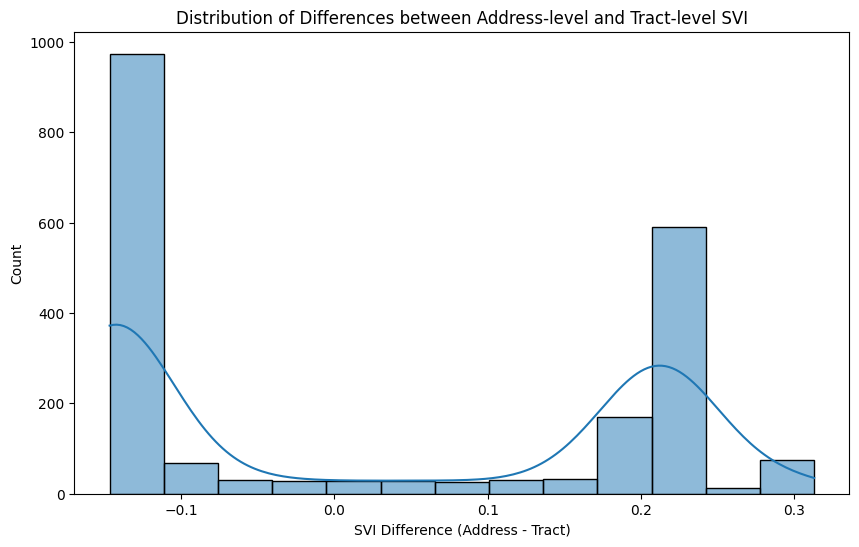

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate summary statistics
summary_stats = address_df_with_both_svi['svi_difference'].describe()
print("\nSummary statistics of SVI difference:")
print(summary_stats)

# Create a histogram of the SVI differences
plt.figure(figsize=(10, 6))
sns.histplot(address_df_with_both_svi['svi_difference'], kde=True)
plt.title('Distribution of Differences between Address-level and Tract-level SVI')
plt.xlabel('SVI Difference (Address - Tract)')
plt.ylabel('Count')
plt.show()


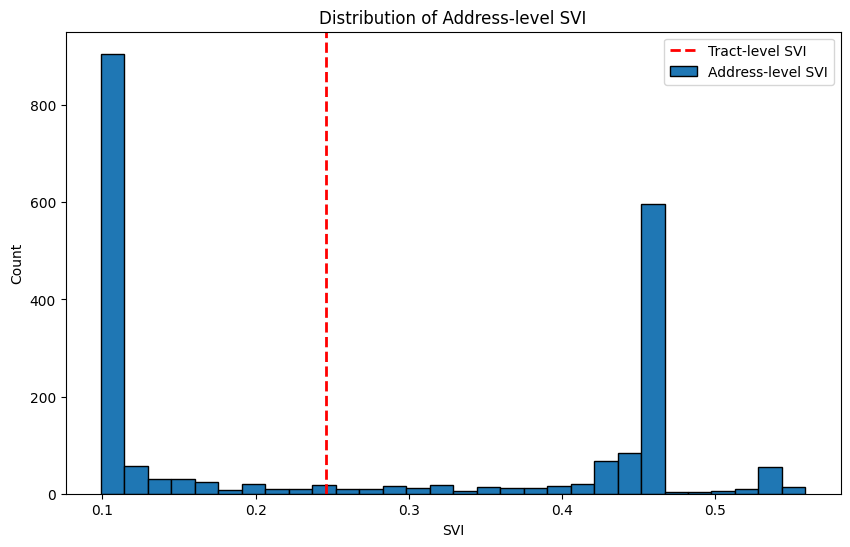

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(address_df_with_both_svi['address_level_svi'], bins=30, edgecolor='black')
plt.axvline(address_df_with_both_svi['tract_level_svi'].iloc[0], color='r', linestyle='dashed', linewidth=2)
plt.title('Distribution of Address-level SVI')
plt.xlabel('SVI')
plt.ylabel('Count')
plt.legend(['Tract-level SVI', 'Address-level SVI'])
plt.show()

### Visualization

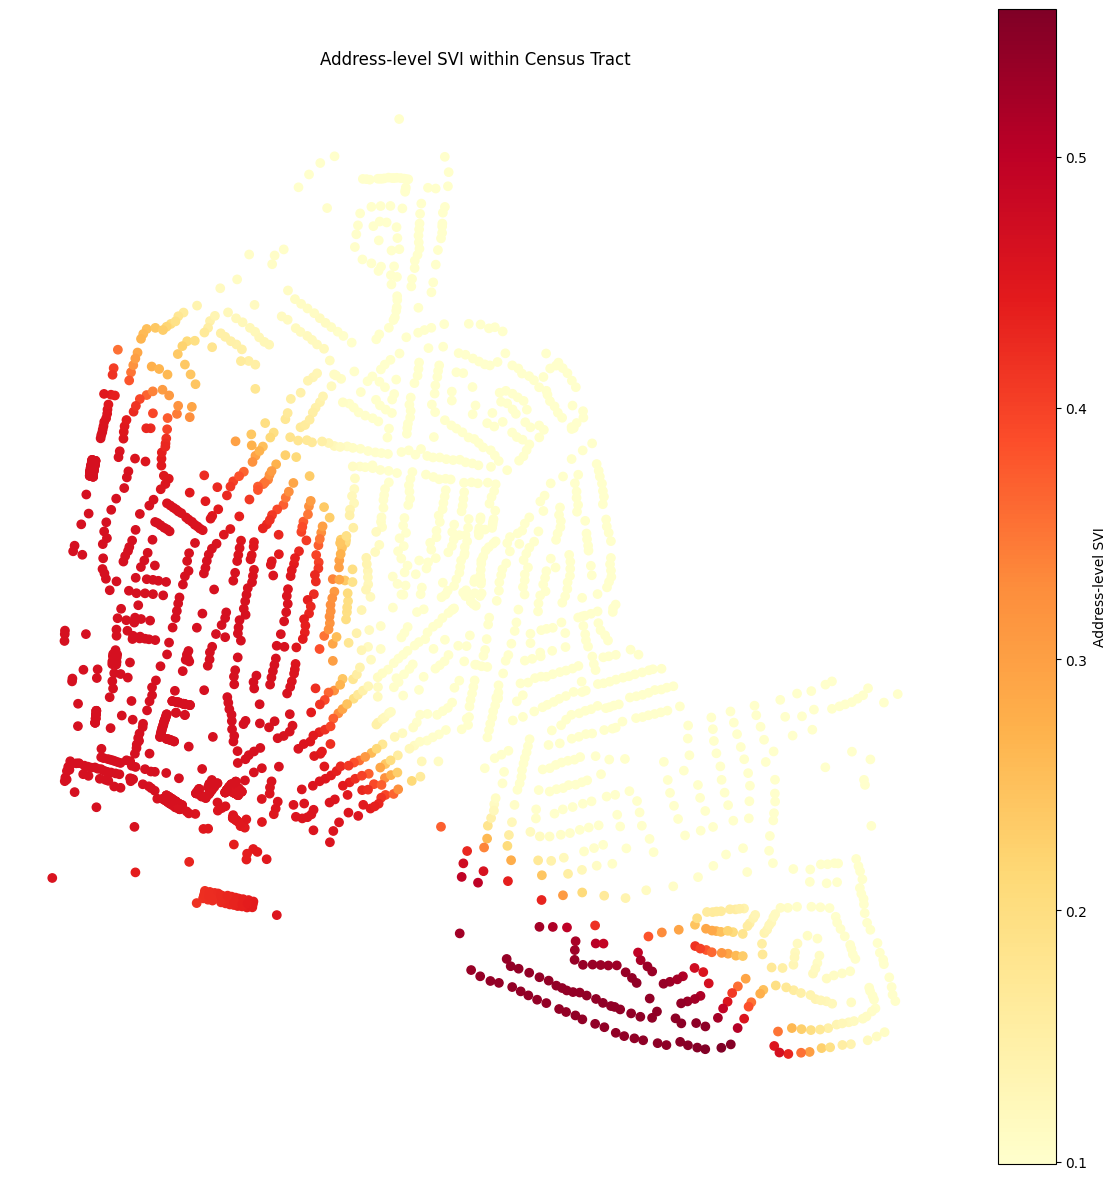

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
address_df_with_both_svi.plot(column='address_level_svi', cmap='YlOrRd',
                              legend=True, ax=ax, legend_kwds={'label': 'Address-level SVI'})
plt.title('Address-level SVI within Census Tract')
plt.axis('off')
plt.show()

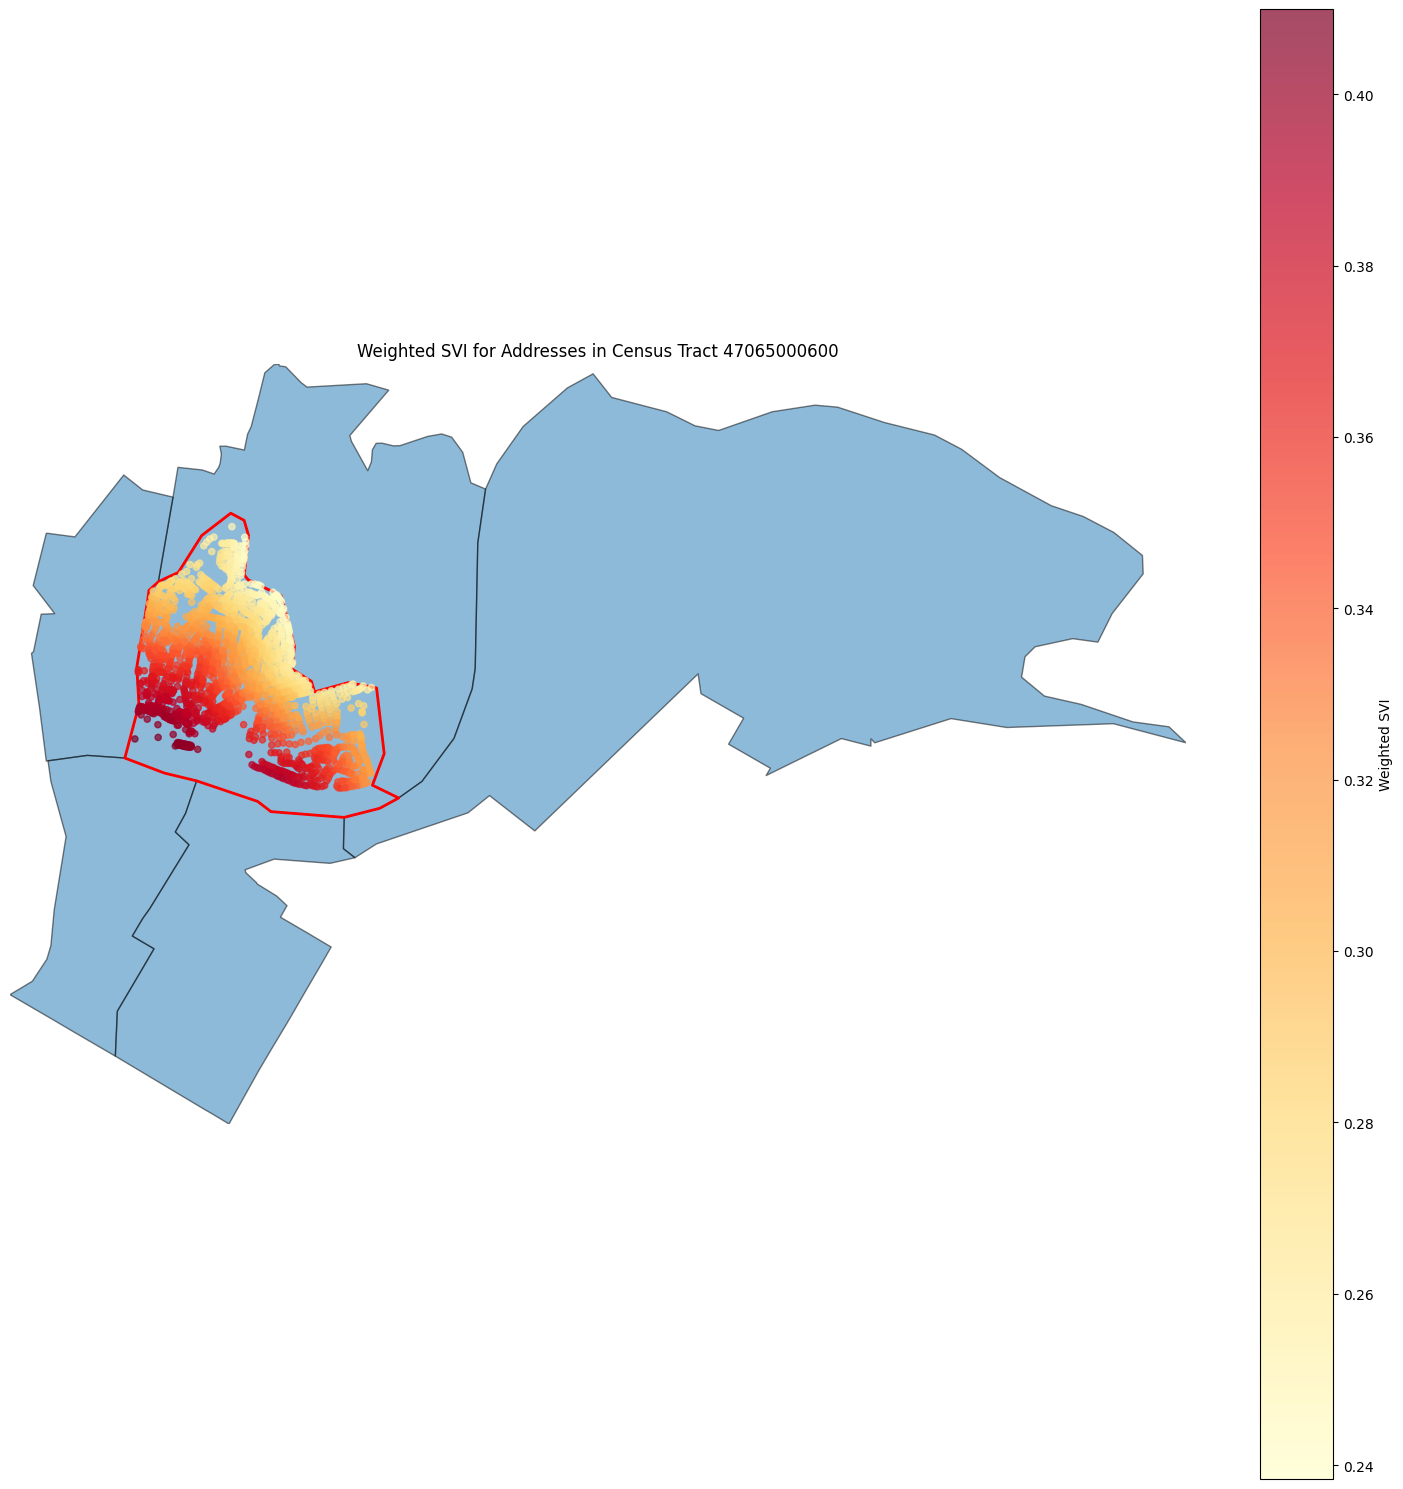

In [22]:
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame

def visualize_address_svi(target_fips, svi_df, address_df_with_svi):
    # Get the target tract
    target_tract = svi_df[svi_df['FIPS'] == target_fips].iloc[0]

    # Find neighboring tracts
    neighboring_tracts = svi_df[svi_df.geometry.touches(target_tract.geometry)]

    # Combine target and neighboring tracts
    tracts_to_plot = pd.concat([svi_df[svi_df['FIPS'] == target_fips], neighboring_tracts])

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot all tracts
    tracts_to_plot.plot(ax=ax, alpha=0.5, edgecolor='k')

    # Highlight the target tract
    target_gdf = GeoDataFrame([target_tract], geometry='geometry')
    target_gdf.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=2)

    # Plot the addresses, colored by weighted SVI
    addresses_in_target = address_df_with_svi[address_df_with_svi['target_fips'] == target_fips]
    scatter = ax.scatter(
        addresses_in_target.geometry.x,
        addresses_in_target.geometry.y,
        c=addresses_in_target['weighted_svi'],
        cmap='YlOrRd',  # Yellow-Orange-Red colormap, typically used for SVI
        s=20,
        alpha=0.7
    )

    # Add a colorbar
    plt.colorbar(scatter, label='Weighted SVI')

    # Set the plot extent to focus on the target and neighboring tracts
    ax.set_xlim(tracts_to_plot.total_bounds[0], tracts_to_plot.total_bounds[2])
    ax.set_ylim(tracts_to_plot.total_bounds[1], tracts_to_plot.total_bounds[3])

    plt.title(f'Weighted SVI for Addresses in Census Tract {target_fips}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
target_fips = '47065000600'  # Example FIPS code
visualize_address_svi(target_fips, svi_df, address_df_with_svi)